# Modeling

In [1]:
# Imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.linear_model as skl
import sklearn.model_selection as skm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm
import time
import itertools

In [2]:
# Data Preparation
df = pd.read_csv(r"C:\Users\kaavy\OneDrive\Documents\qtm 347\cleaned_HK_AirBnB_Data_new.csv")
df.drop(['id', 'name', 'host_id', 'host_name'], axis=1, inplace=True)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), np.log(df['price']), test_size=0.2, random_state=42) # split data into test and train

In [4]:
# Setup Cross Validation
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

In [14]:
# PCR Model with PCA

# set up pipeline
scaler = StandardScaler()
pca = PCA()
linreg = LinearRegression()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])

pipe.fit(X_train, y_train) # fit the training data
print(pipe.named_steps['linreg'].coef_)


[ 3.37827637e-01 -5.04270422e-02  3.92420300e-02 -4.72711433e-02
 -1.47210667e-01  5.51856065e-02 -2.02563674e-01 -6.85261980e-02
  1.27196612e-02  2.68207050e-02  8.61580126e-03  9.10076101e-04
 -5.38107994e-03  8.22395916e-03  9.01847454e-03  2.65035753e-02
  1.60497144e-02 -9.15865178e-03  1.28596073e-02 -7.94971763e-03
 -6.24023546e-02 -4.92345677e-02 -3.81361320e-02 -3.15292055e-02
  4.67549014e-02 -2.02275011e-01 -1.95516478e-01  1.78206455e-01
  5.70856719e-03  3.33941031e-02  3.48283844e+11  2.17677403e+10]


In [15]:
# Grid Search for PCA Components
param_grid = {'pca__n_components': range(1, 34)} 
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error') # search for optimal number of components
grid.fit(X_train, y_train) # fit training data

c:\Users\kaavy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 165.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kaavy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kaavy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\kaavy\AppData\Local\Programs\Python\Python310\lib\site-packages

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 34)},
             scoring='neg_mean_squared_error')

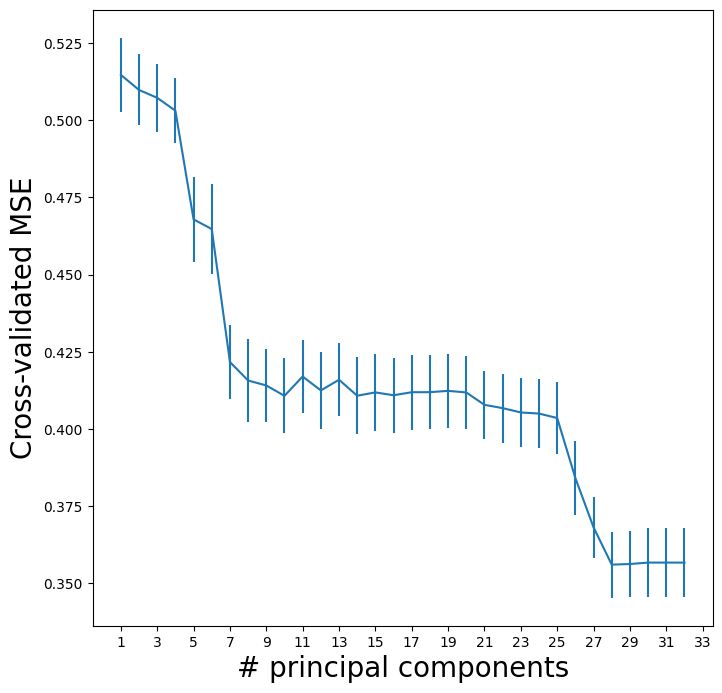

In [18]:
# Plot PCA Results - MSE for each potential number of components
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])

In [17]:
predictions = grid.predict(X_test)
print(mean_squared_error(y_test, predictions)) # MSE

0.35271260638635676


In [9]:
# ElasticNet Model
# search for optimal alpha and l1_ratio
elastic_net = ElasticNet(random_state=0)
param_grid_en = {'alpha': [0.1, 1, 10, 100], 'l1_ratio': np.arange(0.0, 1.0, 0.1)}
grid_search_en = GridSearchCV(elastic_net, param_grid_en, cv=kfold, scoring='neg_mean_squared_error')
grid_search_en.fit(X_train, y_train)
print("Best parameters found: ", grid_search_en.best_params_)

c:\Users\kaavy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.523e+02, tolerance: 3.473e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\kaavy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.997e+02, tolerance: 3.601e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Best parameters found:  {'alpha': 0.1, 'l1_ratio': 0.0}


c:\Users\kaavy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.749e+02, tolerance: 4.406e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [10]:
# Print MSE and Feature Importance from ElasticNet
y_pred_en = grid_search_en.predict(X_test)
print("MSE from ElasticNet: ", mean_squared_error(y_test, y_pred_en))
feature_importance_en = np.abs(grid_search_en.best_estimator_.coef_)
important_features_en = np.argsort(feature_importance_en)[::-1]
print("Most Important Features by Elastic Net Model:")
for i in important_features_en[:12]:
    print(df.columns[i], feature_importance_en[i])

MSE from ElasticNet:  0.3745649673077748
Most Important Features by Elastic Net Model:
number_of_reviews_ltm 0.31238445980933865
room_type_Private room 0.1881145719411999
room_type_Hotel room 0.1178107522619633
room_type_Shared room 0.10703494475827034
bed_count 0.07770169619765732
bathroom_count 0.06731545783382425
district_Sham Shui Po 0.05878023197314195
district_Wong Tai Sin 0.04814192932581981
district_Sha Tin 0.03252408454143267
district_Sai Kung 0.030689151672270893
district_Tuen Mun 0.028986124876202706
district_Eastern 0.028653761111114368


## Gradient Boosting Model

In [11]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
import time

In [12]:
start_time = time.time()

boost_boston = GBR(n_estimators=5000,
                   learning_rate=0.001, 
                   max_depth=3, 
                   random_state=0)
boost_boston.fit(X_train, y_train)

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Elapsed time: 35.072657108306885 seconds


In [13]:
# find optimal num of estimators, depths, samples per splits

num_estimators = np.arange(20, 401, 40)
num_depths = np.arange(1,11,2)
num_samples_per_splits = np.arange(2,11,2)


param_grid = {'n_estimators': num_estimators, 
              'max_depth': num_depths,
              'min_samples_split': num_samples_per_splits
             }

boost = GBR(learning_rate=0.02, 
            max_depth=1, 
            random_state=0)

kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10) 

grid = skm.GridSearchCV(boost,
                        param_grid,
                        refit=True,
                        cv=kfold, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1) # n_jobs=-1 means use all available processors to parallelize

G = grid.fit(X_train, y_train)

best_ = grid.best_estimator_
print(grid.best_params_, np.mean((y_test - best_.predict(X_test))**2)) # mse

{'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 380} 0.1859914076373864
